Analyse de Forme : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant    
import scipy.stats as stats
import missingno as msno
from sklearn.ensemble import IsolationForest

dataset = pd.read_csv("sets/train.csv")
df = dataset.copy()

print(df.head())
print(df.shape)
print(df.dtypes.value_counts())
print(df.describe())

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

In [5]:
print(df["trip_duration"].describe())

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64


In [6]:
print(df.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64


<Axes: >

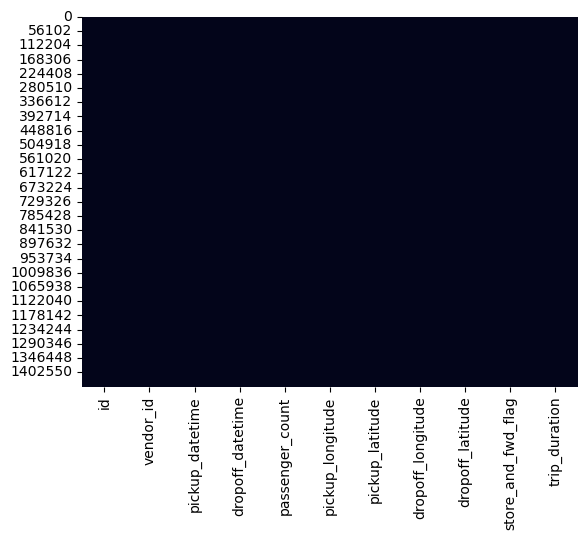

In [7]:
missing_values = df.isna().sum()/df.shape[0]
print(missing_values)
sns.heatmap(df.isna(), cbar=False)

Analyse de fond : 

In [2]:
numerical_features = df.select_dtypes(exclude="object").columns
qualitative_features = df.select_dtypes(include="object").columns

skewness = df[numerical_features].skew().sort_values(ascending=False)
kurtosis = df[numerical_features].kurt().sort_values(ascending=False)
variance = df[numerical_features].var().sort_values(ascending=False)

print(skewness["trip_duration"])
print(kurtosis["trip_duration"])
print(variance["trip_duration"])

343.1639435917362
192131.51730712678
27430691.068774126


In [3]:
main_statistics = pd.DataFrame({"skewness":skewness, "kurtosis":kurtosis, "variance":variance})

In [11]:
print(main_statistics["variance"])

dropoff_latitude     1.288132e-03
dropoff_longitude    4.990471e-03
passenger_count      1.727232e+00
pickup_latitude      1.081172e-03
pickup_longitude     5.027074e-03
trip_duration        2.743069e+07
vendor_id            2.487786e-01
Name: variance, dtype: float64


In [12]:
print(df[qualitative_features].nunique())

id                    1458644
pickup_datetime       1380222
dropoff_datetime      1380377
store_and_fwd_flag          2
dtype: int64


store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64


<Axes: xlabel='store_and_fwd_flag', ylabel='count'>

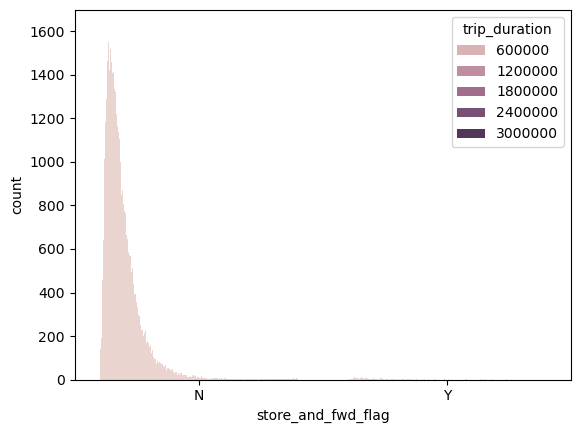

In [13]:
print(df["store_and_fwd_flag"].value_counts())
sns.countplot(x=df["store_and_fwd_flag"], hue=df["trip_duration"])

<Axes: >

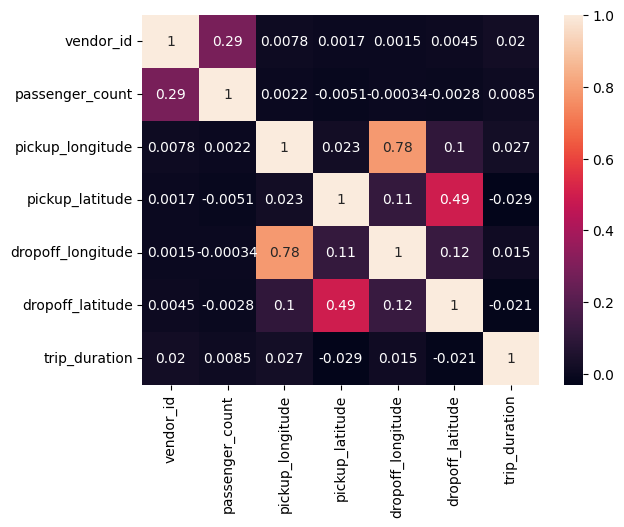

In [4]:
num_correlation = df[numerical_features].corr()
sns.heatmap(num_correlation, annot=True)

In [ ]:
print(df.info())

Détection des Outliers : 

In [5]:
def outliers_detection(df):
    # liste d'anomalies
    anomalies = []

    # Limite supérieur et inférieur à 3 écarts types
    data_std = statistics.stdev(df)
    data_mean = statistics.mean(df)
    anomaly_cut_off = data_std * 3

    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    # Génère les outliers
    for outlier in df:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    
    return anomalies

In [18]:
for col in numerical_features:
    outliers = outliers_detection(df[col])
    print(f"{col} : ", len(outliers))


vendor_id :  0
passenger_count :  48338
pickup_longitude :  367
pickup_latitude :  33563
dropoff_longitude :  2474
dropoff_latitude :  17298
trip_duration :  2073


<Axes: >

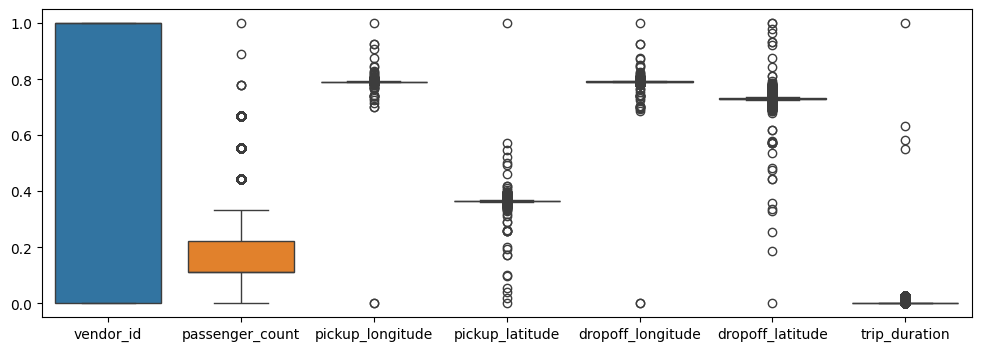

In [7]:
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df[numerical_features]), columns=numerical_features)
scaled_df = pd.concat([scaled_df, df[qualitative_features]], axis=1)

plt.figure(figsize=(12, 4))
sns.boxplot(data=scaled_df)